# Installs

In [6]:
!pip install fcapy[all]
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

In [1]:
import torch

In [7]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cuda118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cuda118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cuda118.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to c:\users\admin\appdata\local\temp\pip-req-build-tjaif_dc
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit cf786b735ab4c1782d8a66c43aecb323b61f8c33
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git 'C:\Users\Admin\AppData\Local\Temp\pip-req-build-tjaif_dc'


# Import libs

In [2]:
import numpy as np
import pandas as pd
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)
import neural_lib as nl
from pathlib import Path

In [3]:
#local
data_cat = Path.cwd().parent.parent / 'datasets'

In [ ]:
#colab / github
data_cat = Path.cwd() / 'datasets'

In [4]:
report = pd.DataFrame(columns=['dataset', 'train_ratio', 'concepts', 'f1_scope', 'accuracy'])

# Dateset 1 - bike_buyers

In [28]:
df = pd.read_csv(data_cat/'bike_bin.csv', index_col=0)
df = df == 1
df.index = df.index.astype(str)
df.columns = [f.split('_')[-1] for f in df.columns]
df.head()

,10000-60000,60000-170000,0,1-4,0-1 Miles,1-2 Miles,10+ Miles,2-5 Miles,5-10 Miles,Male,Purchased
0,True,False,True,False,True,False,False,False,False,False,False
1,True,False,False,True,True,False,False,False,False,True,False
2,False,True,False,True,False,False,False,True,False,True,False
3,False,True,False,True,False,False,False,False,True,True,True
4,True,False,True,False,True,False,False,False,False,True,True


Split the data to train and test

In [29]:
df_bin = df  # Skip this part as the data is already binary
y_feat = 'Purchased'
df_test = df_bin.loc['800':]
df_train = df_bin.drop(df_test.index, axis=0)
X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]

Put binarized data in FormalContext and compute monotone ConceptLattice

In [7]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (800 objects, 10 attributes, 2801 connections)
   |10000-60000|60000-170000|0|1-4|0-1 Miles|1-2 Miles|10+ Miles|2-5 Miles|5-10 Miles|Male|
0  |          X|            |X|   |        X|         |         |         |          |    |
1  |          X|            | |  X|        X|         |         |         |          |   X|
2  |           |           X| |  X|         |         |         |        X|          |   X|
3  |           |           X| |  X|         |         |         |         |         X|   X|
4  |          X|            |X|   |        X|         |         |         |          |   X|
5  |          X|            |X|   |         |        X|         |         |          |    |
6  |           |           X| |  X|        X|         |         |         |          |   X|
7  |          X|            |X|   |        X|         |         |         |          |   X|
8  |          X|            | |  X|         |         |         |         |         X|   X|
9  |          X|   

In [8]:
%%time

L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

CPU times: total: 45.2 s
Wall time: 45.2 s


487

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [9]:
from sklearn.metrics import f1_score, accuracy_score
from frozendict import frozendict

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    updated_measures = dict(c.measures)
    updated_measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures = frozendict(updated_measures)

Select indices of the best concepts from the lattice

In [10]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:8])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [11]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [12]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

Move the nodes in visualization to make it look pretty

In [13]:
descr = {'Male', '0-1', '0-1 Miles'}

traced = cn.trace_description(descr, include_targets=False)

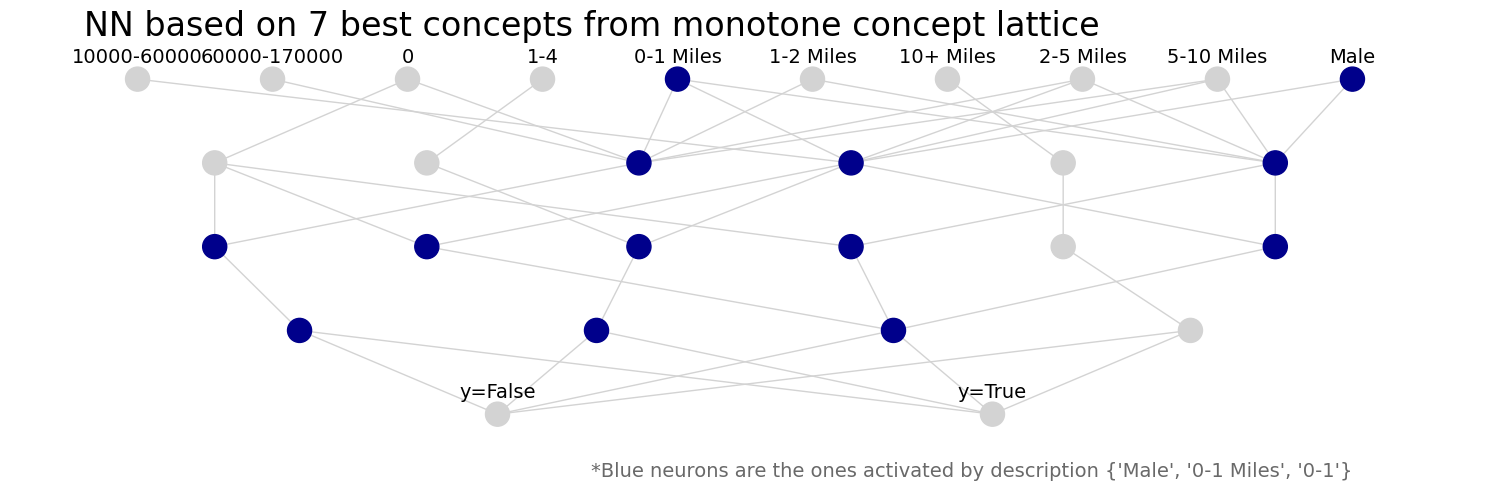

In [14]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now fit the network

In [15]:
cn.fit(X_train, y_train)

To obtain the prediction

In [16]:
y_pred = cn.predict(X_test).numpy()
#print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
#print('True class', y_test.values)
print('f1_score', f1_score(y_test.values, y_pred))
print('accuracy', accuracy_score(y_test.values, y_pred))

Class prediction with probabilities [[0.4141795  0.58582056]
 [0.4638889  0.53611106]
 [0.67827684 0.3217231 ]
 [0.67827684 0.3217231 ]
 [0.5222304  0.47776952]
 [0.7684868  0.23151328]
 [0.9079277  0.09207229]
 [0.8018711  0.19812886]
 [0.862317   0.13768302]
 [0.7684868  0.23151328]
 [0.5766962  0.42330378]
 [0.71992886 0.2800712 ]
 [0.8018711  0.19812886]
 [0.8018711  0.19812886]
 [0.8018711  0.19812886]
 [0.862317   0.13768302]
 [0.22954544 0.7704545 ]
 [0.22954544 0.7704545 ]
 [0.67827684 0.3217231 ]
 [0.7684868  0.23151328]
 [0.4638889  0.53611106]
 [0.4638889  0.53611106]
 [0.67827684 0.3217231 ]
 [0.24062341 0.75937665]
 [0.4141795  0.58582056]
 [0.71992886 0.2800712 ]
 [0.22954544 0.7704545 ]
 [0.41442505 0.585575  ]
 [0.7684868  0.23151328]
 [0.4141795  0.58582056]
 [0.4638889  0.53611106]
 [0.4141795  0.58582056]
 [0.22954544 0.7704545 ]
 [0.4141795  0.58582056]
 [0.41442505 0.585575  ]
 [0.22954544 0.7704545 ]
 [0.7684868  0.23151328]
 [0.22954544 0.7704545 ]
 [0.41442505 0

Let us look at the fitted weights of edges

In [17]:
edge_weights = cn.edge_weights_from_network()

D:\ProgramFiles\anaconda3\envs\FCA\lib\site-packages\sparselinear\sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:607.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


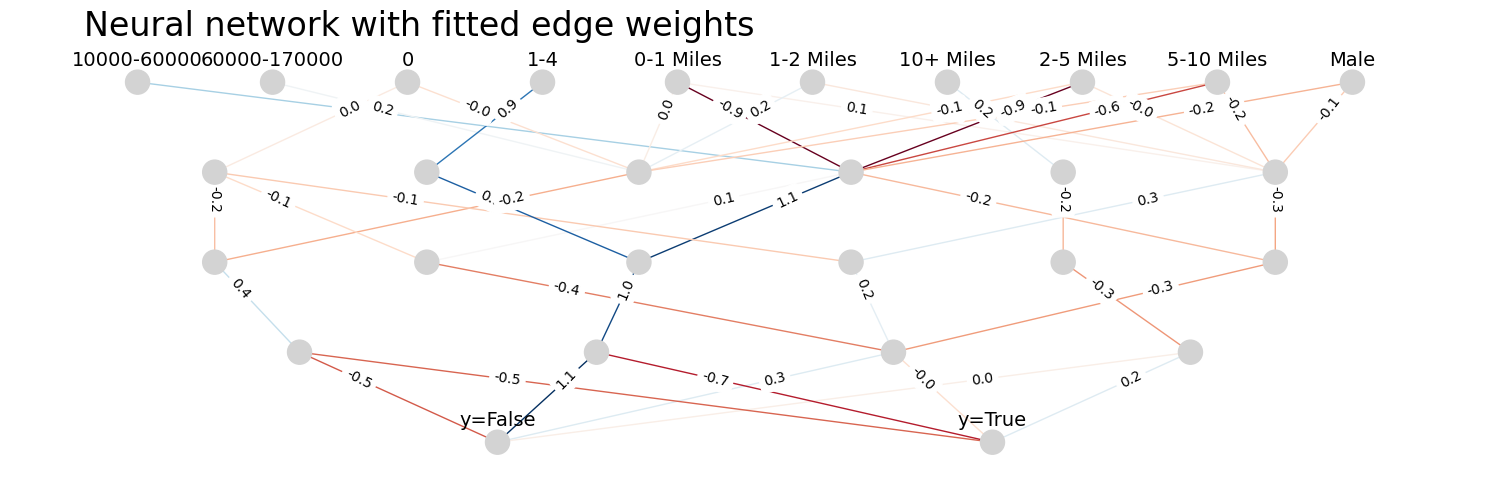

In [18]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

In [30]:
report.loc['bikes'] = [int(2), df_train.shape[0] / df_bin.shape[0], 8, 0.6, 0.64]
report

,dataset,train_ratio,concepts,f1_scope,accuracy
bikes,2.0,0.800000,8.0,0.600000,0.640000
car_accept,3.0,0.411523,15.0,0.935484,0.958042


# Dateset 2 - car_accept

In [23]:
df = pd.read_csv(data_cat/'car_bin.csv', index_col=0)
df.index = df.index.astype(str)
df.columns = [''.join([f.split('_')[0][:3], '_', f.split('_')[-1]]) for f in df.columns]
df = df == 1
df

,Buy_high,Buy_low,Buy_med,Mai_high,Mai_low,Mai_med,Per_2,Per_4,Per_more,Saf_high,Saf_low,Saf_med,Car_Acceptability
0,True,False,False,True,False,False,True,False,False,False,True,False,False
1,True,False,False,True,False,False,True,False,False,False,False,True,False
2,True,False,False,True,False,False,True,False,False,True,False,False,False
3,True,False,False,True,False,False,True,False,False,False,True,False,False
4,True,False,False,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,False,True,False,False,True,False,False,False,True,False,False,True,True
968,False,True,False,False,True,False,False,False,True,True,False,False,True
969,False,True,False,False,True,False,False,False,True,False,True,False,False
970,False,True,False,False,True,False,False,False,True,False,False,True,True


Split the data to train and test

In [24]:
df_bin = df  # Skip this part as the data is already binary
y_feat = 'Car_Acceptability'
train_idx = df_bin[df_bin[y_feat] == 1].index[:200] # половина положительных классов
train_idx = train_idx.append(df_bin[df_bin[y_feat] == 0].index[:200]) # половина отрицательных классов
df_train = df_bin.loc[train_idx]
df_test = df_bin.drop(train_idx)
X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]

Put binarized data in FormalContext and compute monotone ConceptLattice

In [25]:
K_train = FormalContext(data=X_train.values, target=y_train.values, attribute_names=X_train.columns)
K_train

FormalContext (400 objects, 12 attributes, 1600 connections)
   |Buy_high|Buy_low|Buy_med|Mai_high|Mai_low|...|Per_4|Per_more|Saf_high|Saf_low|Saf_med|
0  |       X|       |       |       X|       |...|    X|        |       X|       |       |
1  |       X|       |       |       X|       |...|    X|        |       X|       |       |
2  |       X|       |       |       X|       |...|    X|        |        |       |      X|
3  |       X|       |       |       X|       |...|    X|        |       X|       |       |
4  |       X|       |       |       X|       |...|     |       X|       X|       |       |
5  |       X|       |       |       X|       |...|     |       X|        |       |      X|
6  |       X|       |       |       X|       |...|     |       X|       X|       |       |
7  |       X|       |       |       X|       |...|    X|        |       X|       |       |
8  |       X|       |       |       X|       |...|    X|        |       X|       |       |
9  |       X|       |       |

In [79]:
%%time

L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

CPU times: total: 2min 7s
Wall time: 2min 7s


659

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [80]:
from sklearn.metrics import f1_score, accuracy_score
from frozendict import frozendict

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    updated_measures = dict(c.measures)
    updated_measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures = frozendict(updated_measures)

Select indices of the best concepts from the lattice

In [92]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:15])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [93]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [94]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [96]:
descr = {'Buy_high', 'Saf_low', 'Mai_med'}

traced = cn.trace_description(descr, include_targets=False)

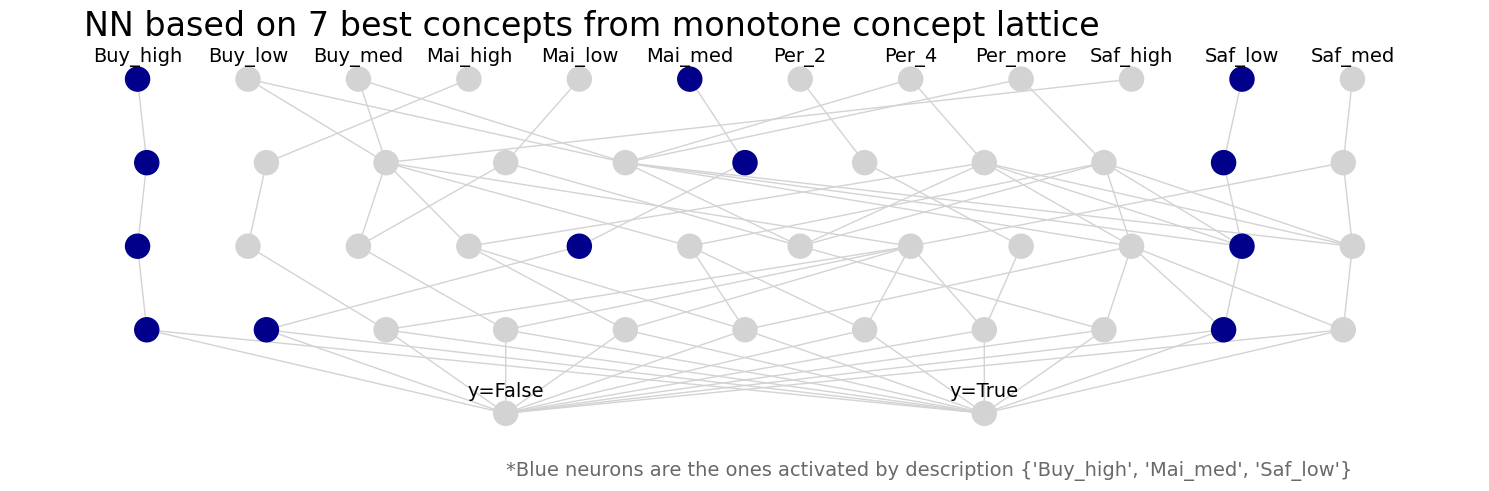

In [97]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now fit the network

In [98]:
cn.fit(X_train, y_train)

To obtain the prediction

In [99]:
y_pred = cn.predict(X_test).numpy()
#print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
#print('True class', y_test.values)
print('f1_score', f1_score(y_test.values, y_pred))
print('accuracy', accuracy_score(y_test.values, y_pred))

Class prediction with probabilities [[0.9977196  0.00228037]
 [0.9977196  0.00228037]
 [0.9986297  0.00137031]
 ...
 [0.97319555 0.02680449]
 [0.02704986 0.97295016]
 [0.02704986 0.97295016]]
f1_score 0.9354838709677419
accuracy 0.958041958041958


Let us look at the fitted weights of edges

In [100]:
edge_weights = cn.edge_weights_from_network()

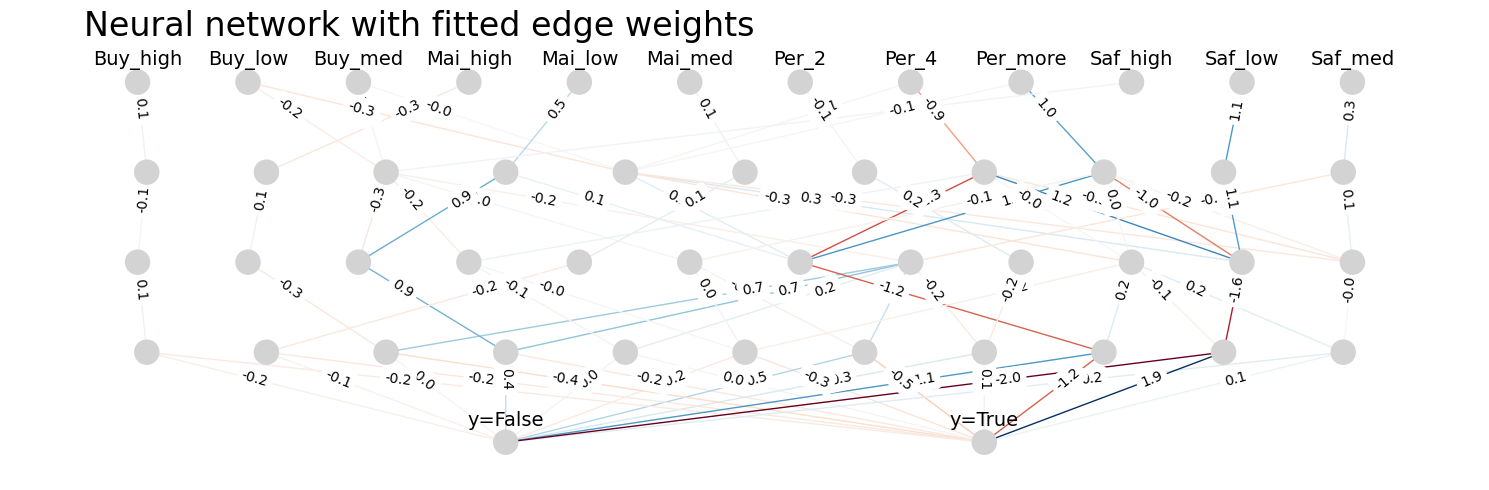

In [101]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

In [27]:
report.loc['car_accept'] = [int(3), df_train.shape[0] / df_bin.shape[0], 15, 0.9354838709677419, 0.958041958041958]
report

,dataset,train_ratio,concepts,f1_scope,accuracy
bikes,3.0,0.411523,15.0,0.935484,0.958042
car_accept,3.0,0.411523,15.0,0.935484,0.958042


# Dataset 3

In [31]:
df = pd.read_csv(data_cat/'bank_bin.csv', index_col=0)
df.index = df.index.astype(str)
#df.columns = [''.join([f.split('_')[0][:3], '_', f.split('_')[-1]]) for f in df.columns]
df = df == 1
df

,big_age,high_educ,has_job,default,housing,loan,cell_cont,before_con,influence_ccon,long_dur,poutcome,y
0,False,True,True,False,True,True,True,True,True,True,False,False
1,True,False,False,False,True,True,False,False,False,True,False,True
2,False,True,True,False,False,True,True,False,True,False,False,False
3,True,True,False,False,True,True,False,False,True,True,False,False
4,False,True,True,False,True,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
24300,False,False,True,False,False,True,False,False,False,True,False,False
24301,True,True,True,False,False,True,False,True,False,False,False,False
24302,True,False,True,False,True,False,False,False,True,False,False,False
24303,False,True,True,False,True,True,True,False,False,False,False,False


<Axes: >

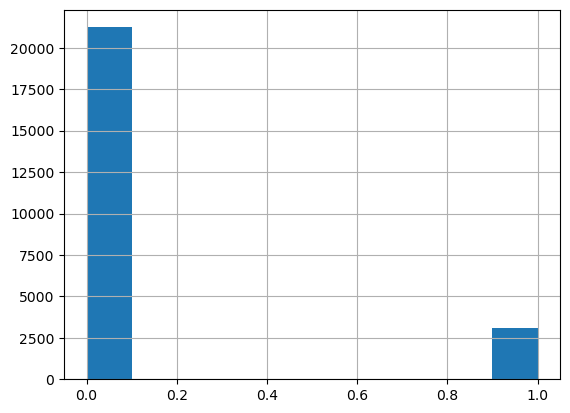

In [32]:
df.y.astype(int).hist()

Split the data to train and test

In [33]:
y_feat = 'y'
df_bin = df.loc[df[df[y_feat] == 1].index[:2500].append(df[df[y_feat] == 0].index[:2500])]  # Skip this part as the data is already binary
train_idx = df_bin[df_bin[y_feat] == 1].index[:400] # половина положительных классов
train_idx = train_idx.append(df_bin[df_bin[y_feat] == 0].index[:400]) # половина отрицательных классов
df_train = df_bin.loc[train_idx]
df_test = df_bin.drop(train_idx)
X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]

Put binarized data in FormalContext and compute monotone ConceptLattice

In [184]:
K_train = FormalContext(data=X_train.values, target=y_train.values, attribute_names=X_train.columns)
K_train

FormalContext (800 objects, 11 attributes, 3954 connections)
   |big_age|high_educ|has_job|default|housing|...|cell_cont|before_con|influence_ccon|long_dur|poutcome|
0  |      X|         |       |       |      X|...|         |          |              |       X|        |
1  |       |         |       |       |      X|...|        X|          |              |       X|        |
2  |      X|         |      X|       |       |...|         |          |              |       X|        |
3  |       |        X|      X|       |      X|...|         |         X|             X|       X|       X|
4  |      X|        X|       |       |      X|...|         |         X|             X|       X|       X|
5  |      X|        X|      X|       |      X|...|         |         X|             X|       X|        |
6  |       |        X|      X|       |       |...|         |          |              |       X|        |
7  |      X|         |      X|       |       |...|         |          |             X|       X|    

In [185]:
%%time

L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

CPU times: total: 2min 59s
Wall time: 2min 59s


501

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [186]:
from sklearn.metrics import f1_score, accuracy_score
from frozendict import frozendict

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    updated_measures = dict(c.measures)
    updated_measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures = frozendict(updated_measures)

Select indices of the best concepts from the lattice

In [187]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:30])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

AssertionError: Selected concepts do not cover all train objects

Construct neural network based on concept lattice

In [188]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [189]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [174]:
descr = {'has_job', 'long_dur', 'Mai_med'}

traced = cn.trace_description(descr, include_targets=False)

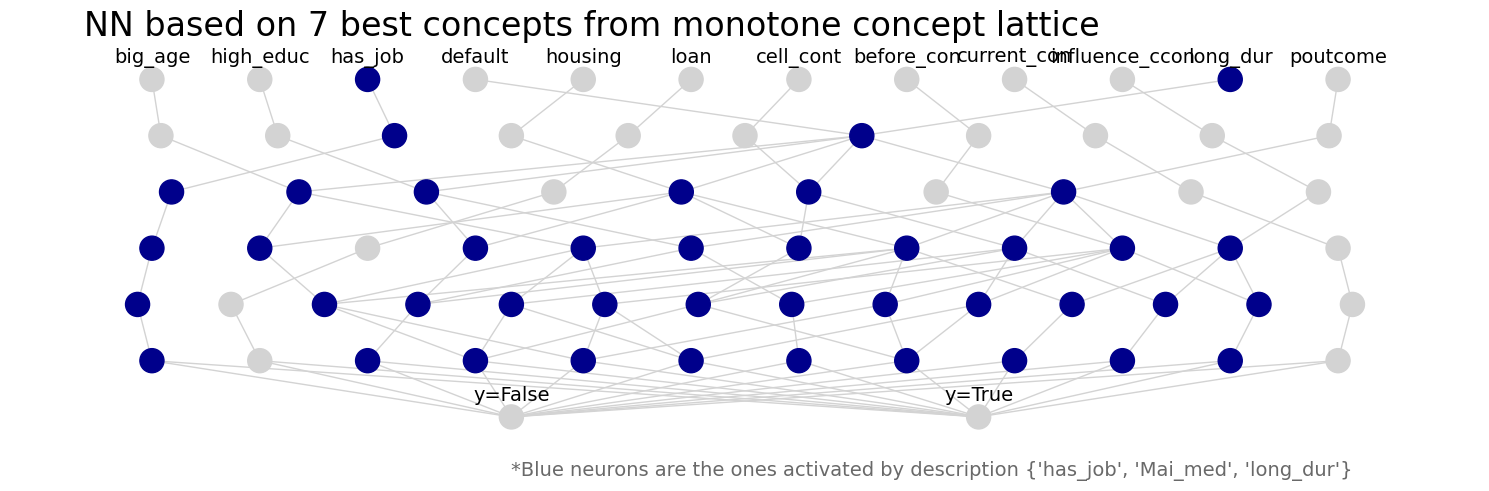

In [175]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now fit the network

In [190]:
cn.fit(X_train, y_train)

To obtain the prediction

In [192]:
y_pred = cn.predict(X_test).numpy()
#print('Class prediction', cn.predict(X_test).numpy())
print('Class prediction with probabilities', cn.predict_proba(X_test).detach().numpy())
#print('True class', y_test.values)
print('f1_score', f1_score(y_test.values, y_pred))
print('accuracy', accuracy_score(y_test.values, y_pred))

Class prediction with probabilities [[3.0265710e-01 6.9734287e-01]
 [9.9965727e-01 3.4274993e-04]
 [3.0265710e-01 6.9734287e-01]
 ...
 [9.9952376e-01 4.7621073e-04]
 [9.9952376e-01 4.7621073e-04]
 [9.9965727e-01 3.4274993e-04]]
f1_score 0.7590140558158484
accuracy 0.7183333333333334


Let us look at the fitted weights of edges

In [193]:
edge_weights = cn.edge_weights_from_network()

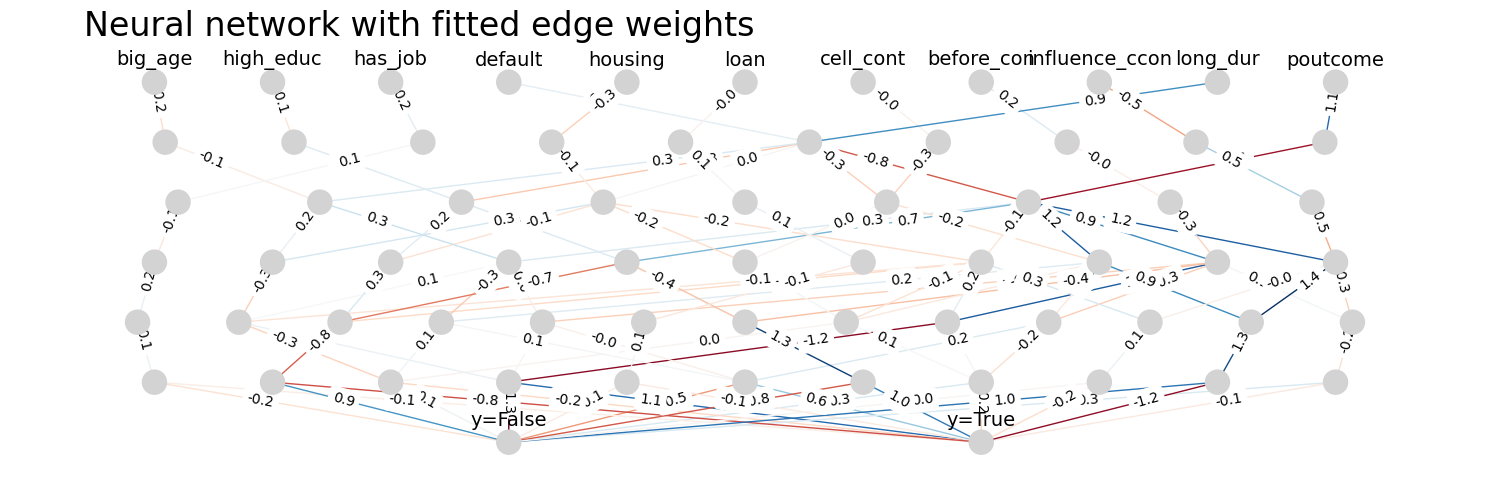

In [194]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

In [34]:
report.loc['bank'] = [int(1), df_train.shape[0] / df_bin.shape[0], 30, 0.7590140558158484, 0.7183333333333334]
report

,dataset,train_ratio,concepts,f1_scope,accuracy
bikes,2.0,0.800000,8.0,0.600000,0.640000
car_accept,3.0,0.411523,15.0,0.935484,0.958042
bank,1.0,0.160000,30.0,0.759014,0.718333


In [36]:
report.sort_values('dataset', inplace=True)
report[['dataset', 'concepts']] = report[['dataset', 'concepts']].astype(int)
report

,dataset,train_ratio,concepts,f1_scope,accuracy
bank,1,0.160000,30,0.759014,0.718333
bikes,2,0.800000,8,0.600000,0.640000
car_accept,3,0.411523,15,0.935484,0.958042


In [37]:
report.to_csv('Neural_FCA_report.csv')